# TFX Interactive Data Analysis 

1. Prepare the data in BigQuery.
2. ExampleGen on BigQuery.
3. StatisticsGen and SchemaGen to generate and fix TFDV schema


In [1]:
!pip install tfx --quiet

## Dataset

The [Chicago Taxi Trips](https://pantheon.corp.google.com/marketplace/details/city-of-chicago-public-data/chicago-taxi-trips) dataset is one of [public datasets hosted with BigQuery](https://cloud.google.com/bigquery/public-data/), which includes taxi trips from 2013 to the present, reported to the City of Chicago in its role as a regulatory agency. The `taxi_trips` table size is 70.72 GB and includes more than 195 million records. The dataset includes information about the trips, like pickup and dropoff datetime and location, passengers count, miles travelled, and trip toll. 

The ML task is to predict whether a given trip will result in a tip > 20%.

## Setup

### Import libraries

In [2]:
import os
import pandas as pd
#import tensorflow as tf
import tensorflow_data_validation as tfdv
import matplotlib.pyplot as plt
from google.cloud import bigquery

2022-06-16 03:19:42.905165: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-16 03:19:42.905207: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Setup Google Cloud project

In [3]:
output=!gcloud config list --format 'value(core.project)'
PROJECT_ID=output[0]
REGION = 'us-central1'

### Set configurations

In [4]:
BQ_DATASET_NAME = 'public_dataset' # Change to your BQ dataset name.
BQ_TABLE_NAME = 'chicago_taxitrips_prep'
BQ_LOCATION = 'US'
DATASET_DISPLAY_NAME = 'chicago-taxi-tips'

## Explore the data in BigQuery

In [5]:
%%bigquery data

SELECT 
    CAST(EXTRACT(DAYOFWEEK FROM trip_start_timestamp) AS string) AS trip_dayofweek, 
    FORMAT_DATE('%A',cast(trip_start_timestamp as date)) AS trip_dayname,
    COUNT(*) as trip_count,
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE
    EXTRACT(YEAR FROM trip_start_timestamp) = 2015 
GROUP BY
    trip_dayofweek,
    trip_dayname
ORDER BY
    trip_dayofweek
;

Downloading: 100%|██████████| 7/7 [00:02<00:00,  2.95rows/s]


In [6]:
data

,trip_dayofweek,trip_dayname,trip_count
0,1,Sunday,4141154
1,2,Monday,4105900
2,3,Tuesday,4378805
3,4,Wednesday,4542810
4,5,Thursday,4918190
5,6,Friday,5289830
6,7,Saturday,5009186


<AxesSubplot:xlabel='trip_dayname'>

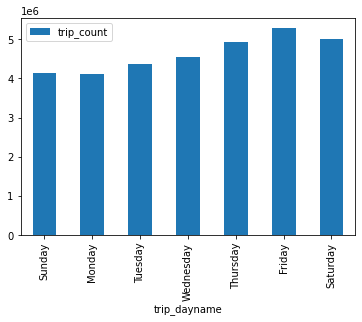

In [7]:
data.plot(kind='bar', x='trip_dayname', y='trip_count')

## Train/Test data split

Add a `ML_use` column for pre-splitting the data, where 80% of the datsa items are set to `UNASSIGNED` while the other 20% is set to `TEST`. This column is used during training to split the dataset for training and test. In the training phase, the `UNASSIGNED` are split into `train` and `eval`. The `TEST` split is will be used for the final model validation.

### Create destination BigQuery dataset

In [8]:
!bq --location=US mk -d \
$PROJECT:$BQ_DATASET_NAME

BigQuery error in mk operation: Cannot determine dataset described by :


In [9]:
#sample_size = 1000000
sample_size = 10000
year = 2020

In [10]:
sql_script = '''
CREATE OR REPLACE TABLE `@PROJECT.@DATASET.@TABLE` 
AS (
    WITH
      taxitrips AS (
      SELECT
        trip_start_timestamp,
        trip_seconds,
        trip_miles,
        payment_type,
        pickup_longitude,
        pickup_latitude,
        dropoff_longitude,
        dropoff_latitude,
        tips,
        fare
      FROM
        `bigquery-public-data.chicago_taxi_trips.taxi_trips`
      WHERE 1=1 
      AND pickup_longitude IS NOT NULL
      AND pickup_latitude IS NOT NULL
      AND dropoff_longitude IS NOT NULL
      AND dropoff_latitude IS NOT NULL
      AND trip_miles > 0
      AND trip_seconds > 0
      AND fare > 0
      AND EXTRACT(YEAR FROM trip_start_timestamp) = @YEAR
    )

    SELECT
      trip_start_timestamp,
      EXTRACT(MONTH from trip_start_timestamp) as trip_month,
      EXTRACT(DAY from trip_start_timestamp) as trip_day,
      EXTRACT(DAYOFWEEK from trip_start_timestamp) as trip_day_of_week,
      EXTRACT(HOUR from trip_start_timestamp) as trip_hour,
      trip_seconds,
      trip_miles,
      payment_type,
      ST_AsText(
          ST_SnapToGrid(ST_GeogPoint(pickup_longitude, pickup_latitude), 0.1)
      ) AS pickup_grid,
      ST_AsText(
          ST_SnapToGrid(ST_GeogPoint(dropoff_longitude, dropoff_latitude), 0.1)
      ) AS dropoff_grid,
      ST_Distance(
          ST_GeogPoint(pickup_longitude, pickup_latitude), 
          ST_GeogPoint(dropoff_longitude, dropoff_latitude)
      ) AS euclidean,
      CONCAT(
          ST_AsText(ST_SnapToGrid(ST_GeogPoint(pickup_longitude,
              pickup_latitude), 0.1)), 
          ST_AsText(ST_SnapToGrid(ST_GeogPoint(dropoff_longitude,
              dropoff_latitude), 0.1))
      ) AS loc_cross,
      IF((tips/fare >= 0.2), 1, 0) AS tip_bin,
      IF(RAND() <= 0.8, 'UNASSIGNED', 'TEST') AS ML_use
    FROM
      taxitrips
    LIMIT @LIMIT
)
'''

In [11]:
sql_script = sql_script.replace(
    '@PROJECT', PROJECT_ID).replace(
    '@DATASET', BQ_DATASET_NAME).replace(
    '@TABLE', BQ_TABLE_NAME).replace(
    '@YEAR', str(year)).replace(
    '@LIMIT', str(sample_size))

In [12]:
print(sql_script)


CREATE OR REPLACE TABLE `gcp-egl-demand-fcast-dev-a0fd.public_dataset.chicago_taxitrips_prep` 
AS (
    WITH
      taxitrips AS (
      SELECT
        trip_start_timestamp,
        trip_seconds,
        trip_miles,
        payment_type,
        pickup_longitude,
        pickup_latitude,
        dropoff_longitude,
        dropoff_latitude,
        tips,
        fare
      FROM
        `bigquery-public-data.chicago_taxi_trips.taxi_trips`
      WHERE 1=1 
      AND pickup_longitude IS NOT NULL
      AND pickup_latitude IS NOT NULL
      AND dropoff_longitude IS NOT NULL
      AND dropoff_latitude IS NOT NULL
      AND trip_miles > 0
      AND trip_seconds > 0
      AND fare > 0
      AND EXTRACT(YEAR FROM trip_start_timestamp) = 2020
    )

    SELECT
      trip_start_timestamp,
      EXTRACT(MONTH from trip_start_timestamp) as trip_month,
      EXTRACT(DAY from trip_start_timestamp) as trip_day,
      EXTRACT(DAYOFWEEK from trip_start_timestamp) as trip_day_of_week,
      EXTRACT(HOUR f

In [13]:
bq_client = bigquery.Client(project=PROJECT_ID, location=BQ_LOCATION)
job = bq_client.query(sql_script)
_ = job.result()

In [14]:
%%bigquery --project {PROJECT_ID}

SELECT ML_use, COUNT(*)
FROM public_dataset.chicago_taxitrips_prep # Change to your BQ dataset and table names.
GROUP BY ML_use

Downloading: 100%|██████████| 2/2 [00:02<00:00,  1.04s/rows]


,ML_use,f0_
0,UNASSIGNED,8021
1,TEST,1979


### Explore in a Pandas DataFrame

In [15]:
%%bigquery sample_data --project {PROJECT_ID}

SELECT * EXCEPT (trip_start_timestamp, ML_use)
FROM public_dataset.chicago_taxitrips_prep # Change to your BQ dataset and table names.

Downloading: 100%|██████████| 10000/10000 [00:03<00:00, 2805.14rows/s]


In [16]:
sample_data.head().T

,0,1,2,3,4
trip_month,2,2,2,2,2
trip_day,5,28,2,28,7
trip_day_of_week,4,6,1,6,6
trip_hour,16,9,4,20,14
trip_seconds,204,225,540,229,756
trip_miles,0.6,0.7,3.9,0.69,2.25
payment_type,Cash,Cash,Credit Card,Cash,Cash
pickup_grid,POINT(-87.6 42),POINT(-87.6 42),POINT(-87.7 42),POINT(-87.7 42),POINT(-87.7 42)
dropoff_grid,POINT(-87.6 42),POINT(-87.6 42),POINT(-87.6 42),POINT(-87.6 42),POINT(-87.7 42)
euclidean,0.0,0.0,4974.139154,1323.124925,3000.241665


In [17]:
sample_data.tip_bin.value_counts()

0    6542
1    3458
Name: tip_bin, dtype: int64

<AxesSubplot:>

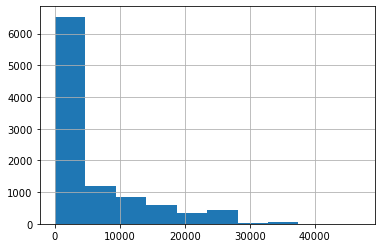

In [18]:
sample_data.euclidean.hist()

---
# Explore data with TFX Interactive

* [Introducing the TFX interactive notebook](https://blog.tensorflow.org/2019/11/introducing-tfx-interactive-notebook.html)

> Now you can build, debug, and run your TFX pipeline inside an interactive Google Colab or Jupyter notebook! Within this notebook environment, you can run TFX component-by-component, which makes it easier to iterate and experiment on your ML pipeline.

* [TFX Keras Component Tutorial](https://www.tensorflow.org/tfx/tutorials/tfx/components_keras)

> This notebook demonstrates how to use TFX in a Jupyter/Colab environment. Here, we walk through the Chicago Taxi example in an interactive notebook. When you're done, the contents of this notebook can be automatically exported as TFX pipeline source code, which you can orchestrate with Apache Airflow and Apache Beam.

* [TFX Components Walk-through
Learning Objectives](https://notebook.community/GoogleCloudPlatform/mlops-on-gcp/workshops/tfx-caip-tf21/lab-01-tfx-walkthrough/lab-01) (MUST)



In [19]:
!rm -rf ./data/artifacts
!mkdir -p ./data/artifacts

In [20]:
import os
from tfx.orchestration.experimental.interactive.interactive_context import InteractiveContext
from tfx.v1.extensions.google_cloud_big_query import BigQueryExampleGen
from tfx.v1.components import (
    StatisticsGen,
    SchemaGen,
)

%load_ext tfx.orchestration.experimental.interactive.notebook_extensions.skip

#context = InteractiveContext(pipeline_root='./data/artifacts')
context = InteractiveContext()

## BigQueryExampleGen

* [Colab InteractiveContext Unable to Determine ProjectID for BQ #882](https://github.com/tensorflow/tfx/issues/882)

> The issue appears when running this in a notebook with the BigQueryExampleGen with the error ```Request missing required parameter projectId```.  
> I have proposed [#888](https://github.com/tensorflow/tfx/pull/888) to make this work. With that change, you would be able to do 
> ```
> context.run(..., beam_pipeline_args=['--project', 'my-project'])
> ```

* [Allow beam_pipeline_args to be specified in interactive context.run(). #888](https://github.com/tensorflow/tfx/pull/888)
* [BigQueryExampleGen broken ReadFromBigQuery requires a GCS location to be provided #2293](https://github.com/tensorflow/tfx/issues/2293)

> need to provide --temp_location as part of the beam pipeline arg, and set that to a GCS location

* [ValueError in Dataflow: Invalid GCS location: None](https://stackoverflow.com/questions/68325195/valueerror-in-dataflow-invalid-gcs-location-none)

> When running your Dataflow pipeline pass the argument ```--temp_location gs://bucket/subfolder/```

## Tutorial

* [TensorFlow Extended (TFX): Using Apache Beam for large scale data processing](https://blog.tensorflow.org/2020/03/tensorflow-extended-tfx-using-apache-beam-large-scale-data-processing.html)
* [Reading data from BigQuery with TFX and Vertex Pipelines ](https://www.tensorflow.org/tfx/tutorials/tfx/gcp/vertex_pipelines_bq)

> This notebook-based tutorial will use Google Cloud BigQuery as a data source to train an ML model. The ML pipeline will be constructed using TFX and run on Google Cloud Vertex Pipelines. In this tutorial, we will use the **BigQueryExampleGen** component which reads data from BigQuery to TFX pipelines.  
> 
> 
> We also **need to pass beam_pipeline_args** for the BigQueryExampleGen. It includes configs like **the name of the GCP project and the temporary storage** for the BigQuery execution.


In [21]:
BUCKET = "gs://" + PROJECT_ID + "-bucket"
!gsutil mb $BUCKET

Creating gs://gcp-egl-demand-fcast-dev-a0fd-bucket/...
ServiceException: 409 A Cloud Storage bucket named 'gcp-egl-demand-fcast-dev-a0fd-bucket' already exists. Try another name. Bucket names must be globally unique across all Google Cloud projects, including those outside of your organization.


In [22]:
query = """
SELECT 
    * EXCEPT (trip_start_timestamp, ML_use)
FROM 
    {PROJECT_ID}.public_dataset.chicago_taxitrips_prep
""".format(PROJECT_ID=PROJECT_ID)

from tfx.proto import example_gen_pb2
output = example_gen_pb2.Output(
    split_config=example_gen_pb2.SplitConfig(splits=[
        example_gen_pb2.SplitConfig.Split(name='train', hash_buckets=6),
        example_gen_pb2.SplitConfig.Split(name='eval', hash_buckets=2),
        example_gen_pb2.SplitConfig.Split(name='test', hash_buckets=2)
    ]
))


SHARED_VPC_PROJECT_ID = "gcp-egl-sharedvpc-np-7de5"
SHARED_VPC_SUBNETWORK_NAME = "gcp-egl-us-central1-172-21-208-0-non-prod"

example_gen = context.run(
    BigQueryExampleGen(query=query),
    beam_pipeline_args=[
        '--runner=DataflowRunner',
        f'--project={PROJECT_ID}',
        f'--region={REGION}',
        f'--staging_location={BUCKET}/staging',
        f'--temp_location={BUCKET}',
        f'--dataflow_service_option=enable_secure_boot',
        f'--no_use_public_ips',
        f'--subnetwork=https://www.googleapis.com/compute/v1/projects/{SHARED_VPC_PROJECT_ID}/regions/{REGION}/subnetworks/{SHARED_VPC_SUBNETWORK_NAME}',
#        f'--service_account_email=vertex-ai-agent-sa@${PROJECT_ID}.iam.gserviceaccount.com'
    ]
)

/opt/conda/lib/python3.7/site-packages/apache_beam/io/gcp/bigquery.py:2471: BeamDeprecationWarning: options is deprecated since First stable release. References to <pipeline>.options will not be supported
  temp_location = pcoll.pipeline.options.view_as(


In [23]:
for artifact in example_gen.component.outputs['examples'].get():
    print(artifact)

Artifact(artifact: id: 1
type_id: 14
uri: "/tmp/tfx-interactive-2022-06-16T03_20_04.802384-ztyjqr28/BigQueryExampleGen/examples/1"
properties {
  key: "split_names"
  value {
    string_value: "[\"train\", \"eval\"]"
  }
}
custom_properties {
  key: "file_format"
  value {
    string_value: "tfrecords_gzip"
  }
}
custom_properties {
  key: "payload_format"
  value {
    string_value: "FORMAT_TF_EXAMPLE"
  }
}
custom_properties {
  key: "span"
  value {
    int_value: 0
  }
}
custom_properties {
  key: "state"
  value {
    string_value: "published"
  }
}
custom_properties {
  key: "tfx_version"
  value {
    string_value: "1.8.0"
  }
}
state: LIVE
, artifact_type: id: 14
name: "Examples"
properties {
  key: "span"
  value: INT
}
properties {
  key: "split_names"
  value: STRING
}
properties {
  key: "version"
  value: INT
}
base_type: DATASET
)


In [24]:
dir(example_gen)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'component',
 'execution_id']

## StatisticsGen

In [25]:
statistics_gen = context.run(
    StatisticsGen(examples=example_gen.component.outputs['examples'])
)
context.show(statistics_gen.component.outputs['statistics'])

OSError: No files found based on the file pattern /tmp/tfx-interactive-2022-06-16T03_20_04.802384-ztyjqr28/BigQueryExampleGen/examples/1/Split-train/*

## SchemaGen

* [Why isn't SchemaGen supported in tfdv.display_schema()?](https://stackoverflow.com/a/64199301)

In [ ]:
schema_gen = SchemaGen(
    statistics=statistics_gen.component.outputs['statistics'],
    infer_feature_shape=True
)
context.run(schema_gen)
context.show(schema_gen.outputs['schema'])